In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os
import random
os.chdir('../Network-analysis/')
import utilities as util
os.chdir('../src/')

['C:\\Users\\drobi\\Desktop\\uni\\CS4195\\higgs-twitter-network-science\\src', 'C:\\Users\\drobi\\Anaconda3\\python39.zip', 'C:\\Users\\drobi\\Anaconda3\\DLLs', 'C:\\Users\\drobi\\Anaconda3\\lib', 'C:\\Users\\drobi\\Anaconda3', '', 'C:\\Users\\drobi\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\drobi\\Anaconda3\\lib\\site-packages', 'C:\\Users\\drobi\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\drobi\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\drobi\\Anaconda3\\lib\\site-packages\\Pythonwin', '../']


In [2]:
friends_file_path = "../output/higgs-friends-lcc.edgelist"
friends_reply_path = "../output/higgs-friends-reply.edgelist"
friends_mention_path = "../output/higgs-friends-mention.edgelist"
friends_retweet_path = "../output/higgs-friends-retweet.edgelist"

In [3]:
# Read the edge list file into a graph
G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),))
# print(G_reply.edges(data=True))

In [53]:
subgraph_reply_df = pd.DataFrame(subgraph_reply.edges(data=True), columns=['source', 'target', 'attribute'])
# Extract the 'day' attribute from the 'attribute' column and add it as a separate column
subgraph_reply_df['timestamp'] = [d['day'] for d in subgraph_reply_df['attribute']]
min_t = min(subgraph_reply_df['timestamp'])
max_t = max(subgraph_reply_df['timestamp'])

# Hardcoded normalizing to ~1000 timesteps
subgraph_reply_df['day'] = ((subgraph_reply_df['timestamp'] - min_t)/ 600).astype(int)
# Drop the 'attribute' column, which is no longer needed
subgraph_reply_df.drop('attribute', axis=1, inplace=True)

# there are days above 7, so we need to remove them
# subgraph_reply_df = subgraph_reply_df[subgraph_reply_df['day'] <= 7]
#unique_days = subgraph_reply_df['day'].unique()
#print(unique_days)

In [54]:
min_t, max_t

(1341100972, 1341705530)

In [55]:
subgraph_reply_df.sort_values('day')

,source,target,timestamp,day
3268,213163,223789,1341100972,0
1288,677,424732,1341106079,8
4681,8425,150805,1341109596,14
3476,2288,174754,1341111247,17
3465,186184,70301,1341111839,18
...,...,...,...,...
1729,677,142154,1341701387,1000
173,88,195150,1341701308,1000
4131,9021,50244,1341701458,1000
584,15483,97296,1341705530,1007


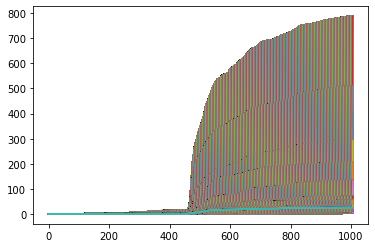

In [56]:
# First implementation of temporal spreading
# From the plot I am not sure if this is correct, the number of infected nodes is pretty low,
# but that could be because the huge majority of interactions happen at time 1, and i am considering a node as spreader from the next day is infected
# if we remove this condition I expect the number of infected nodes to be almost the same as the number of nodes in the subgraph at day 1

subgraph_reply_df = subgraph_reply_df.sort_values(by=['day'])
subgraph_reply_df.reset_index(drop=True, inplace=True)

iterations = 100
infected_nodes_time_dict = {0:[1 for _ in range(iterations)]} 
seed_nodes = []

min_day = min(subgraph_reply_df['day'])
max_day = max(subgraph_reply_df['day'])

for n in range(iterations):
    seed_node = random.choice(list(subgraph_reply.nodes()))
    seed_nodes.append(seed_node)
    infected_nodes = {seed_node}

    cur_timestamp = min_day
    nodes_infected_in_timestamp = set()
    
    # Iterate over all days
    for day in range(min_day, max_day):
        print(f'{n+1}/{iterations} : {day}/{max_day}', end='\r')
        # For each day get the edges that were created on that day
        edges = subgraph_reply_df[subgraph_reply_df['day'] == day]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
        # Make a set of all the nodes that are in susceptible_nodes_rows
        susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
        # Add the susceptible nodes to the infected nodes
        infected_nodes = infected_nodes.union(susceptible_nodes)
        # Add the infected nodes to the infected_nodes_time_dict
        if day in infected_nodes_time_dict:
            infected_nodes_time_dict[day].append(len(infected_nodes))
        else:
            infected_nodes_time_dict[day] = [len(infected_nodes)]
            
        # Take the average of the infected nodes for each timestamp
        infected_nodes_time_dict = {k: [np.sum(v)/len(v)] for k, v in infected_nodes_time_dict.items()}

        plt.plot(list(infected_nodes_time_dict.keys()), list(infected_nodes_time_dict.values()))
